# **1. TorchVision Object Detection Finetuning Tutorial**

MASK R-CNN 모델을 Penn-Fudan Pedestrian Dataset에 파인튜닝 하는 과정

데이터셋은 170장의 보행자 이미지와 345개의 인스턴스로 구성되어 있음

데이터셋은 반드시 torch.utils.data.Dataset을 상속하고 `__len__` , `__getiem__` 같은 메소드를 구현해야됨



`__getitem__` 은 다음을 튜플 (image, target) 형태로 반환해야함

image : `tv_tensors.Image`, 또는 `torch.Tensor` 또는 `PIL.Image`

target : `dict`

target 딕셔너리 필드 구성

`boxes` : [N, 4], [x0, y0, x1, y1] 형식

`labels` : [N], 정수 텐서, 클래스 ID

`image_id` : 고유 식별자 (int)

`area` : [N], 박스 넓이 계산

`iscrowd` : [N], COCO metric 평가 시 군중 여부 (0 or 1)

`masks` (옵션) : [N, H, W], 객체별 마스크

In [ ]:
pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-4irsljv1
  Running command git clone --filter=blob:none --quiet https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-4irsljv1
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Resolved https://github.com/gautamchitnis/cocoapi.git to commit 20291f19c46a8d11935862bc9e449a1b72ec25ed
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=396013 sha256=e721ef6d18f62c3e090ce63bc4ad1c0c84b4ef2591604be0189c15371a5d4827
  Stored in directory: /tmp/pip-ephem-wheel-cache-pe4wl336/wheels/31/00/7e/ad61b2dd166a389f5aaeefc4f4daa087410f5a6049337f5980
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found 

# Writing a custom dataset for PennFudan

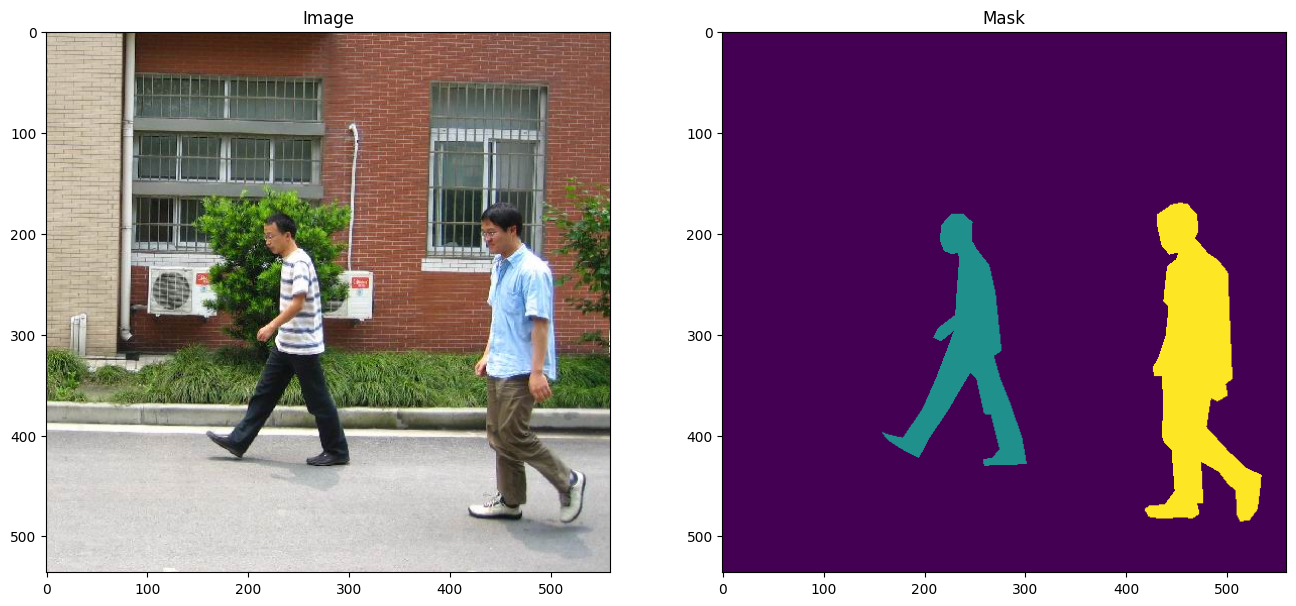

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image('/content/drive/MyDrive/PennFudanPed/PennFudanPed/PNGImages/FudanPed00001.png')
mask = read_image('/content/drive/MyDrive/PennFudanPed/PennFudanPed/PedMasks/FudanPed00001_mask.png')

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Image')
plt.imshow(image.permute(1,2,0))
plt.subplot(122)
plt.title('Mask')
plt.imshow(mask.permute(1, 2, 0))

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms

    # 정렬해서 순서 맞추고 이미지와 마스크 파일 가져옴
    self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
    self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

  def __getitem__(self, idx):
    # 이미지 경로 설정과 로딩
    img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
    mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
    img = read_image(img_path)
    mask = read_image(mask_path)

    # 마스크 고유한 색상값 추출
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:] # 이건 배경이라 제거함
    num_objs = len(obj_ids)

    # 색상 마스크를 바이너리 마스크로 변환
    masks = (mask == obj_ids[:, None, None]).to(dtype = torch.uint8)

    # 마스크의 바운딩 박스를 얻음, (N, 4), XYXY 형
    boxes = masks_to_boxes(masks)

    # 클래스 ID는 1하나임 (보행)
    labels = torch.ones((num_objs,), dtype = torch.int64)
    image_id = idx
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype = torch.int64) # 모든 객체가 crowd가 아니라고 가정

    img = tv_tensors.Image(img) # 텐서로 매핑

    target = {}
    target['boxes'] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size = F.get_size(img))
    target['masks'] = tv_tensors.Mask(masks)
    target['labels'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    # transform 적용
    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

# Defining your model

여기서는 Faster R-CNN을 기반으로하는 Mask R-CNN 모델을 사용함

Faster R-CNN 은 이미지 속 잠재적인 객체들에 대해 바운딩 박스와 클래스 점수를 예측하는 모델임

Mask R-CNN 은 여기에 segmentation mask 를 예측하는 추가적인 branch를 더한 모델임


Torchvision에 있는 모델을 수정하고 싶은 경우는 일반적으로 두가지임

1. 사전학습된 모델을 불러와서 마지막 레이어만 파인튜닝 하는경우
2. 모델의 백본을 다른 네트워크로 교체하고 싶은 경우


# 1 - Finetuning from a pretrained model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 사전학습된 모델 로딩
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

# 클래수 수 정의 (객체 탐지에서는 항상 클래스 0이 배경으로 되어이있음)
num_classes = 2 # 1 class (person) + background

# 기존 classifier의 입력 특징 수 가져오기
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 기존 classifier 교체
# 새롭게 정의한 FastRCNNPredictor로 분류기 대체, 구조는 동일한테 출력 클래수 수만 바꿔줌
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 111MB/s]


# 2 - Modifying the model to add a different backbone

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features

# Faster R-CNN은 백본이 출력하는 채널 수를 알아야 함
backbone.out_channels = 1280

# 각 위치마다 5개의 크기 x 3개의 종횡비 = 즉 15개 anchor box 생성
# 튜플 안에 튜플인 이유는 여러 feature map 에서 각각 다르게 지정할 수 있기 때문
anchor_generator = AnchorGenerator(
    sizes = ((32, 64, 128, 256, 512),),
    aspect_ratios = ((0.5, 1.0, 2.0),)
)

# Region of Interest(ROI)에서 특정 영역을 cropping + 정규화 해서 fixed size feature로 만듬
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names = ['0'], # 사용할 feature map 이름 (backbone이 Tensor를 반환하면 ['0'])
    output_size = 7, # RoI 영역을 7 x 7 크기로 풀링
    sampling_ratio = 2 # RoI 안에서 샘플링할 포인트 수
)

model = FasterRCNN(
    backbone, # 위에서 지정한 MobileNetV2 feature extractor
    num_classes = 2, # 클래스 수 = person 하나 + background
    rpn_anchor_generator = anchor_generator,
    box_roi_pool = roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.4MB/s]


# Object detection and instance segmentation model for PennFudan Dataset

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  # 사전 학습된 Mask R-CNN 모델 가져오기
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')

  # COCO 는 80개 클래스 + background (0번 클래스)
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # 기존 분류기의 입력 피쳐 수는 그대로 사용하되, 출력 클래스 수만 변경한 새 predictor 연결
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # 출력을 우리가 예측할 클래스 수 (num_classes)로 설정해 mask head 교
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask,
      hidden_layer,
      num_classes
  )

  return model

# Putting everything together

train / test를 위한 스크립트 다운로드

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
from torchvision.transforms import v2 as T

def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5)) # 학습 데이터라면 좌우 반전 증강 적용

  # float 타입 변환 및 정규화 (scale = True가 정규화)
  transforms.append(T.ToDtype(torch.float, scale=True))

  # tv_tensors 타입으로 변환 (이미지, 마스크, 바운딩박스로 자동 래핑)
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

# **# Testing `forward()` method**

In [ ]:
# /content/drive/MyDrive/PennFudanPed/PennFudanPed
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT') # 모델 가져오기
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2, # 두 장씩 불러 올거고
    shuffle=True,
    collate_fn=utils.collate_fn # collate_fn 으로 각 이미지 + 타겟을 리스트 형태로 반환
)

# 데이터 하나만 꺼내서
images, targets = next(iter(data_loader))

# 이미지 리스트와 타겟 딕셔너리 리스트로 구
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
print(output) # 모델이 손실과 예측 결과를 반환 할거임

model.eval() # 모델을 인퍼런스 모드로 전환
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) # forward() 호출시 loss는 계산하지 않고, 바운딩 박스 + 클래스 예측 결과만 반환
print(predictions[0])

{'loss_classifier': tensor(0.1568, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1349, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0189, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [ ]:
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/PennFudanPed/PennFudanPed', get_transform(train=False))

# 무작위로 섞고 마지막 50개를 테스트 셋으로 사용
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 2,
    shuffle = True,
    collate_fn = utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 1,
    shuffle = False,
    collate_fn = utils.collate_fn
)

model = get_model_instance_segmentation(num_classes) # 위에서 계속 했던 것

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr = 0.005,
    momentum = 0.9,
    weight_decay = 0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 2

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 163MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:03:18  lr: 0.000090  loss: 5.0154 (5.0154)  loss_classifier: 0.8388 (0.8388)  loss_box_reg: 0.3188 (0.3188)  loss_mask: 3.8377 (3.8377)  loss_objectness: 0.0179 (0.0179)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 3.3148  data: 0.7626  max mem: 2216
Epoch: [0]  [10/60]  eta: 0:01:27  lr: 0.000936  loss: 1.7892 (2.6613)  loss_classifier: 0.5911 (0.5484)  loss_box_reg: 0.3188 (0.2857)  loss_mask: 1.0062 (1.8014)  loss_objectness: 0.0179 (0.0201)  loss_rpn_box_reg: 0.0053 (0.0056)  time: 1.7475  data: 0.9667  max mem: 2762
Epoch: [0]  [20/60]  eta: 0:01:07  lr: 0.001783  loss: 0.9718 (1.7311)  loss_classifier: 0.2594 (0.3746)  loss_box_reg: 0.2304 (0.2620)  loss_mask: 0.4321 (1.0660)  loss_objectness: 0.0187 (0.0224)  loss_rpn_box_reg: 0.0065 (0.0061)  time: 1.6053  data: 1.0181  max mem: 2763
Epoch: [0]  [30/60]  eta: 0:00:47  lr: 0.002629  loss: 0.6389 (1.3524)  loss_classifier: 0.1260 (0.2838)  loss_box_reg: 0.1974 (0.2442)  loss_mask: 0.2286 (0.7979)  loss_ob

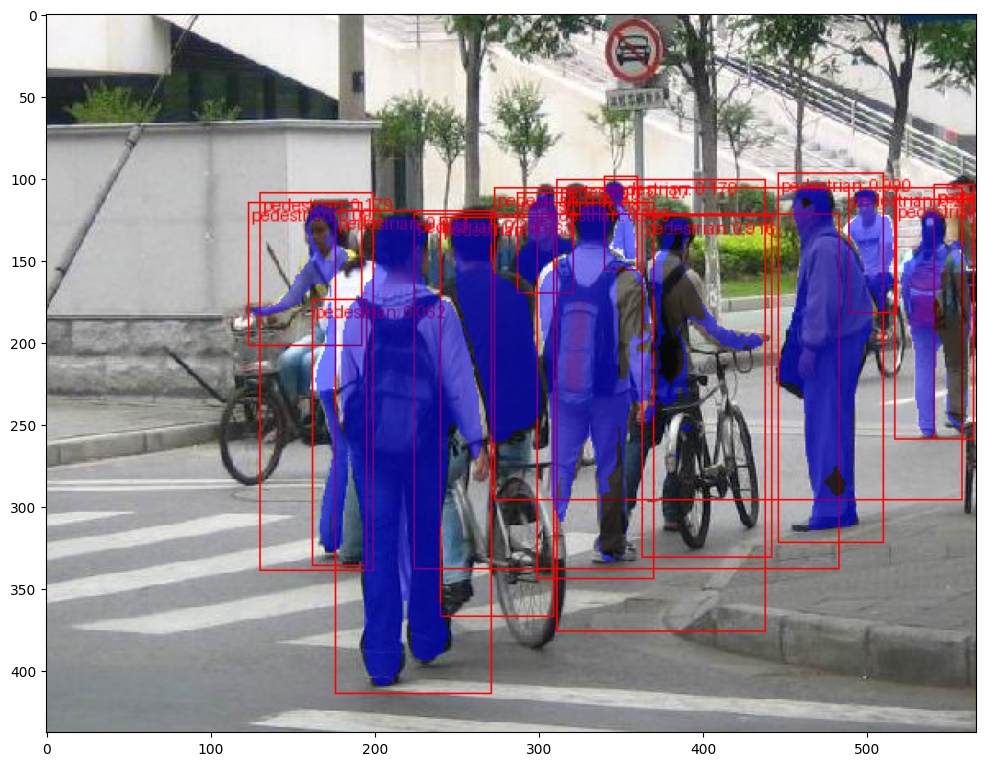

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image('/content/drive/MyDrive/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png')
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3,...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred['labels'], pred['scores'])]
pred_boxes = pred['boxes'].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors='red')

masks = (pred['masks']>0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors='blue')

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1,2,0))